## Load dataset

In [1]:
import numpy as np

from keras import backend as K

np.random.seed(42)

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

n_training_examples = x_train.shape[0]
n_testing_examples = x_test.shape[0]
print('Training data shape: {}'.format(x_train.shape))
print('Number of training examples: {}'.format(n_training_examples))
print('Number of testing examples: {}'.format(n_testing_examples))

Training data shape: (50000, 32, 32, 3)
Number of training examples: 50000
Number of testing examples: 10000


## Set hyperparameters

In [3]:
batch_size = 16
n_epochs = 20
n_classes = 20

## Preprocessing

In [4]:
import keras.utils as k_utils

Y_train = k_utils.to_categorical(y_train, n_classes)
Y_test = k_utils.to_categorical(y_test, n_classes)

print('Y_train shape: {}'.format(Y_train.shape))

Y_train shape: (50000, 20)


## Data generator

In [5]:
from keras.applications.resnet50 import preprocess_input
import cv2

def image_generator(images, labels):
    def generator():
        start = 0
        end = batch_size
        n = len(images)
        while True:
            img_batch_resized = np.array([cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) for img in images[start:end]])
            img_batch_resized = img_batch_resized.astype('float32')
            img_batch_preprocessed = preprocess_input(img_batch_resized)
            label_batch = labels[start:end]
            
            start += batch_size
            end += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (img_batch_preprocessed, label_batch)
    return generator

## Define model

In [6]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)

In [7]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Compile model

In [8]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Fit model

In [9]:
train_datagen = image_generator(x_train, Y_train)

In [10]:
test_datagen = image_generator(x_test, Y_test)

In [11]:
model.fit_generator(train_datagen(), 
                    steps_per_epoch=n_training_examples//batch_size,
                    epochs=2,
                    validation_data=test_datagen(),
                    validation_steps=n_testing_examples//batch_size,
                    verbose=2)

Epoch 1/2
 - 361s - loss: 1.2904 - acc: 0.6101 - val_loss: 1.1396 - val_acc: 0.7050
Epoch 2/2
 - 359s - loss: 0.9689 - acc: 0.7108 - val_loss: 1.3256 - val_acc: 0.7188


## Fine tuning

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable) 

0 input_1 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_1 False
5 max_pooling2d_1 False
6 res2a_branch2a False
7 bn2a_branch2a False
8 activation_2 False
9 res2a_branch2b False
10 bn2a_branch2b False
11 activation_3 False
12 res2a_branch2c False
13 res2a_branch1 False
14 bn2a_branch2c False
15 bn2a_branch1 False
16 add_1 False
17 activation_4 False
18 res2b_branch2a False
19 bn2b_branch2a False
20 activation_5 False
21 res2b_branch2b False
22 bn2b_branch2b False
23 activation_6 False
24 res2b_branch2c False
25 bn2b_branch2c False
26 add_2 False
27 activation_7 False
28 res2c_branch2a False
29 bn2c_branch2a False
30 activation_8 False
31 res2c_branch2b False
32 bn2c_branch2b False
33 activation_9 False
34 res2c_branch2c False
35 bn2c_branch2c False
36 add_3 False
37 activation_10 False
38 res3a_branch2a False
39 bn3a_branch2a False
40 activation_11 False
41 res3a_branch2b False
42 bn3a_branch2b False
43 activation_12 False
44 res3a_branch2c False
45 res3a_branch1 F

In [14]:
for layer in model.layers[:142]:
    layer.trainable = False
for layer in model.layers[142:]:
    layer.trainable = True

In [15]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
train_datagen = image_generator(x_train, Y_train)
test_datagen = image_generator(x_test, Y_test)

history = model.fit_generator(train_datagen(), 
                    steps_per_epoch=n_training_examples//batch_size,
                    epochs=n_epochs,
                    validation_data=test_datagen(),
                    validation_steps=n_testing_examples//batch_size,
                    verbose=2)

Epoch 1/20
 - 445s - loss: 0.6230 - acc: 0.8036 - val_loss: 1.1131 - val_acc: 0.7371
Epoch 2/20
 - 443s - loss: 0.3391 - acc: 0.8989 - val_loss: 1.1319 - val_acc: 0.7441
Epoch 3/20
 - 441s - loss: 0.2095 - acc: 0.9464 - val_loss: 1.1633 - val_acc: 0.7470
Epoch 4/20
 - 440s - loss: 0.1304 - acc: 0.9739 - val_loss: 1.1988 - val_acc: 0.7476
Epoch 5/20
 - 433s - loss: 0.0822 - acc: 0.9883 - val_loss: 1.2324 - val_acc: 0.7482
Epoch 6/20
 - 436s - loss: 0.0536 - acc: 0.9952 - val_loss: 1.2633 - val_acc: 0.7486
Epoch 7/20
 - 437s - loss: 0.0368 - acc: 0.9980 - val_loss: 1.2896 - val_acc: 0.7496
Epoch 8/20
 - 438s - loss: 0.0266 - acc: 0.9992 - val_loss: 1.3127 - val_acc: 0.7495
Epoch 9/20
 - 438s - loss: 0.0203 - acc: 0.9995 - val_loss: 1.3322 - val_acc: 0.7501
Epoch 10/20
 - 438s - loss: 0.0161 - acc: 0.9998 - val_loss: 1.3497 - val_acc: 0.7506
Epoch 11/20
 - 439s - loss: 0.0133 - acc: 0.9998 - val_loss: 1.3656 - val_acc: 0.7512
Epoch 12/20
 - 440s - loss: 0.0112 - acc: 0.9999 - val_loss: 1.

In [17]:
scores = model.evaluate_generator(test_datagen(), n_testing_examples//batch_size)
print("\nTest %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Test acc: 75.24%


## Plot accuracy and loss

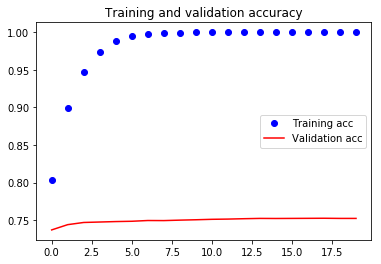

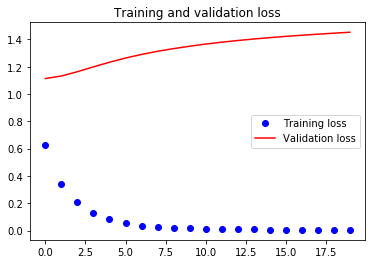

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

References
- https://keras.io/applications/
- The Keras Blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb
- Learn OpenCV https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
- Cifar10 classification experiments https://github.com/rnoxy/cifar10-cnn